## Import

In [1]:
import numpy as np
import pandas as pd
import pickle
import talib
import pywt
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
import warnings ; warnings.filterwarnings('ignore')

## Read data

In [2]:
msft, ma, intc, mcd, aapl = pd.read_pickle('data/total_data.pkl')
display(msft)

,Open,High,Low,Close,Volume,log_return,MA5,MA20,UPPER,MID,...,UNRATE,IR,ER,RS,TB,VIX,NASDAQ,OP,SP500,SOX
2014-01-02,37.349998,37.400002,37.099998,31.290831,30632200.0,-0.006705,31.341517,31.319295,32.674710,31.449548,...,6.7,0.69,1.3670,424784.0,-339.861,14.23,4143.07,95.14,1831.979980,527.750000
2014-01-03,37.200001,37.220001,36.599998,31.080309,31134800.0,-0.006751,31.254448,31.296534,32.431733,31.364079,...,6.7,0.69,1.3606,424784.0,-339.861,13.76,4131.91,93.66,1831.369995,526.679993
2014-01-06,36.849998,36.889999,36.110001,30.423506,43603700.0,-0.021359,30.977467,31.213389,32.386083,31.285348,...,6.7,0.69,1.3636,424784.0,-339.861,13.55,4113.68,93.12,1826.770020,523.770020
2014-01-07,36.330002,36.490002,36.209999,30.659273,35802800.0,0.007720,30.871402,31.160616,32.231168,31.203247,...,6.7,0.69,1.3618,424784.0,-339.861,12.92,4153.18,93.31,1837.880005,527.429993
2014-01-08,36.000000,36.139999,35.580002,30.111944,59971700.0,-0.018013,30.618250,31.060742,31.998363,31.079044,...,6.7,0.69,1.3586,424784.0,-339.861,12.87,4165.61,91.90,1837.489990,535.760010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,333.720001,336.109985,328.489990,327.241577,21520600.0,-0.019349,332.834887,330.023416,343.705424,332.338908,...,3.5,4.47,1.0910,694415.0,-935.445,14.25,13335.78,69.09,4328.819824,3515.770020
2023-06-27,331.859985,336.149994,329.299988,333.186890,24354100.0,0.018005,332.952221,330.324699,343.788182,332.422560,...,3.5,4.47,1.0961,694415.0,-935.445,13.74,13555.67,67.68,4378.410156,3642.409912
2023-06-28,334.660004,337.980011,333.809998,334.461609,20259500.0,0.003819,333.455350,330.718690,343.987721,332.653601,...,3.5,4.47,1.0904,694415.0,-935.445,13.43,13591.75,69.54,4376.859863,3609.479980
2023-06-29,334.709991,336.109985,332.619995,333.664886,16997000.0,-0.002385,333.525196,330.999280,344.026393,332.985223,...,3.5,4.47,1.0881,694415.0,-935.445,13.54,13591.33,69.85,4396.439941,3614.179932


## Split Train-Test data

In [4]:
# Train : Vaild : Test = 8*0.8 : 8*0.2 : 2로 쪼갠다
def splitData(DATA):
    train, test = DATA.iloc[:int(DATA.shape[0]*0.8)], DATA.iloc[int(DATA.shape[0]*0.8):]
    train, vaild = train.iloc[:int(train.shape[0]*0.8)], train.iloc[int(train.shape[0]*0.8):]
    return train, vaild, test

In [6]:
msft_train, msft_vaild, msft_test = splitData(msft)
ma_train, ma_vaild, ma_test = splitData(ma)
intc_train, intc_vaild, intc_test = splitData(intc)
mcd_train, mcd_vaild, mcd_test = splitData(mcd)
aapl_train, aapl_vaild, aapl_test = splitData(aapl)

print(f'train: {msft_train.index[0]} ~ {msft_train.index[-1]}')
print(f'vaild: {msft_vaild.index[0]} ~ {msft_vaild.index[-1]}')
print(f'test: {msft_test.index[0]} ~ {msft_test.index[-1]}')

train: 2014-01-02 00:00:00 ~ 2020-01-29 00:00:00
vaild: 2020-01-30 00:00:00 ~ 2021-08-05 00:00:00
test: 2021-08-06 00:00:00 ~ 2023-06-30 00:00:00


## Wavelet Transformation

## Auto-encoder
- "Application of Deep Learning to Algorithmic Trading(2017)" 논문을 참고하였다.

In [ ]:
# Tenser로 선언
torch.FloatTensor(data.values())

In [ ]:
# 하이퍼파라미터 준비
EPOCH = 10
BATCH_SIZE = 64
DEVICE = torch.device("cpu")

In [5]:
# 오토인코더 모듈 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # 인코더는 간단한 신경망으로 분류모델처럼 생겼습니다.
        self.encoder = nn.Sequential( # nn.Sequential을 사용해 encoder와 decoder 두 모듈로 묶어줍니다.
            nn.Linear(28*28, 128), #차원을 28*28에서 점차 줄여나갑니다.
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),   # 입력의 특징을 3차원으로 압축합니다 (출력값이 바로 잠재변수가 됩니다.)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12), #디코더는 차원을 점차 28*28로 복원합니다.
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # 픽셀당 0과 1 사이로 값을 출력하는 sigmoid()함수를 추가합니다.
        )

    def forward(self, x):
        encoded = self.encoder(x) # encoder는 encoded라는 잠재변수를 만들고
        decoded = self.decoder(encoded) # decoder를 통해 decoded라는 복원이미지를 만듭니다.
        return encoded, decoded

In [6]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005) 
# Adam()을 최적화함수로 사용합니다. Adam은 SGD의 변형함수이며 학습중인 기울기를 참고하여 학습 속도를 자동으로 변화시킵니다.
criterion = nn.MSELoss() #원본값과 디코더에서 나온 값의 차이를 계산하기 위해 평균제곱오차(Mean Squared Loss) 오차함수를 사용합니다.

In [7]:
# 원본 이미지를 시각화 하기 (첫번째 열)
view_data = trainset.data[:5].view(-1, 28*28)
# 복원이 어떻게 되는지 관찰하기 위해 5개의 이미지를 가져와 바로 넣어보겠습니다.
view_data = view_data.type(torch.FloatTensor)/255.
#픽셀의 색상값이 0~255이므로 모델이 인식하는 0부터 1사이의 값으로 만들기 위해 255로 나눠줍니다.

In [8]:
# 학습하기 위한 함수
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE) #x(입력)와 y(대상 레이블)모두 원본이미지(x)인 것을 주의해야 합니다.
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y) # decoded와 원본이미지(y) 사이의 평균제곱오차를 구합니다
        optimizer.zero_grad() #기울기에 대한 정보를 초기화합니다.
        loss.backward() # 기울기를 구합니다.
        optimizer.step() #최적화를 진행합니다.

[Epoch 1]


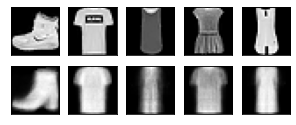

[Epoch 2]


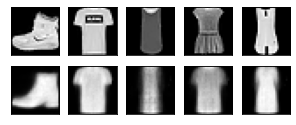

[Epoch 3]


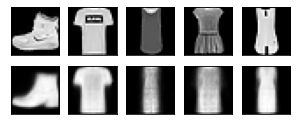

[Epoch 4]


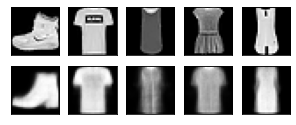

[Epoch 5]


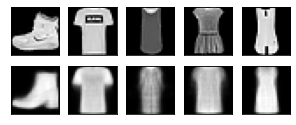

[Epoch 6]


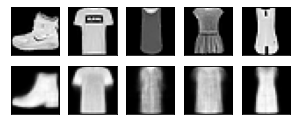

[Epoch 7]


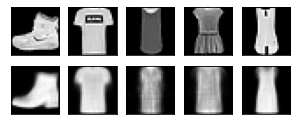

[Epoch 8]


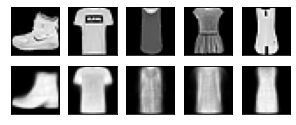

[Epoch 9]


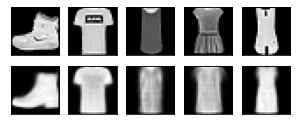

[Epoch 10]


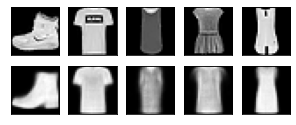

In [9]:
#학습하기
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    # 디코더에서 나온 이미지를 시각화 하기
    # 앞서 시각화를 위해 남겨둔 5개의 이미지를 한 이폭만큼 학습을 마친 모델에 넣어 복원이미지를 만듭니다.
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    # 원본과 디코딩 결과 비교해보기
    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28, 28)) #파이토치 텐서를 넘파이로 변환합니다.
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28)) 
        # CUDA를 사용하면 모델 출력값이 GPU에 남아있으므로 .to("cpu") 함수로 일반메모리로 가져와 numpy행렬로 변환합니다.
        # cpu를 사용할때에도 같은 코드를 사용해도 무방합니다.
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

In [12]:
# 잡음 더하기
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2 
    # 무작위 작음은 torch.randn() 함수로 만들고 img.size()를 넣어 이미지와 같은 크기의 잡음을 만듭니다.
    # 잡음의 강도는 임의로 0.2로 정했습니다.
    noisy_img = img + noise
    return noisy_img

In [13]:
#학습코드에 노이즈더하기 코드 한줄을 추가합니다.
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0
    for step, (x, label) in enumerate(train_loader):
        noisy_x = add_noise(x)  # 입력에 노이즈 더하기
        noisy_x = noisy_x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)

        label = label.to(DEVICE)
        encoded, decoded = autoencoder(noisy_x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item() # 이번에는 평균 오찻값을 관찰하겠습니다.
    return avg_loss / len(train_loader)

In [14]:
for epoch in range(1, EPOCH+1):
    loss = train(autoencoder, train_loader)
    print("[Epoch {}] loss:{}".format(epoch, loss))
    # 이번 예제에선 학습시 시각화를 건너 뜁니다

[Epoch 1] loss:0.023051360896083593
[Epoch 2] loss:0.022633396301553574
[Epoch 3] loss:0.022538402441468066
[Epoch 4] loss:0.022369562822983843
[Epoch 5] loss:0.02227465301823578
[Epoch 6] loss:0.022285325544030427
[Epoch 7] loss:0.02221381103496816
[Epoch 8] loss:0.022156562324541846
[Epoch 9] loss:0.02207331597280782
[Epoch 10] loss:0.022045717062329304


In [15]:
# 잡음제거 시각화
# 모델이 학습시 본적이 없는 데이터로 검증하기 위해 테스트 데이터셋을 가져옵니다.
testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False, #test데이터셋
    download  = True,
    transform = transforms.ToTensor()
)

# 테스트셋에서 이미지 한장을 가져옵니다.
sample_data = testset.data[0].view(-1, 28*28) #1차원 행렬로 변환합니다
sample_data = sample_data.type(torch.FloatTensor)/255.

# 이미지를 add_noise로 오염시킨 후, 모델에 통과시킵니다.
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x) #인코딩된 것은 무시하고 복원된 이미지만 보기 위해 첫 변수는 "_"로 이름 짓습니다.

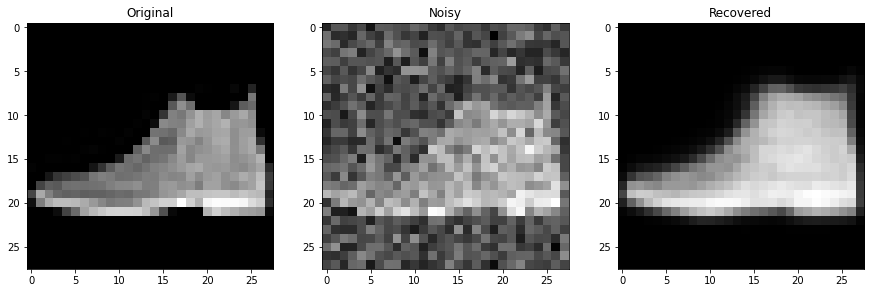

In [16]:
f, a = plt.subplots(1, 3, figsize=(15, 15)) #1행 3열의 표

# 시각화를 위해 넘파이 행렬로 바꿔줍니다.
original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

# 원본 사진
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

# 오염된 원본 사진
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

# 복원된 사진
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()